In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle
import tensorflow as tf


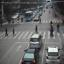

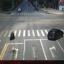

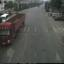

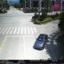

In [16]:
num_classes = 2
from IPython.display import Image,display
listOfImageName=['./image_64/label_64_64_0/361123201502011309E03655_1.JPG',
                './image_64/label_64_64_0/361124201508011107L06095_3.JPG',
                './image_64/label_64_64_1/361125201505011209L55757_3.JPG',
                './image_64/label_64_64_1/361129201504011309EF7139_1.JPG']
for imageName in listOfImageName:
    display(Image(filename=imageName))

In [19]:
x = 10
print x

10


In [4]:
image_size = 64  # Pixel width and height.
channel = 3
pixel_depth = 255.0  # Number of levels per pixel.
folders = ['/Users/meicg/Documents/MATLAB/label_64_0',
            '/Users/meicg/Documents/MATLAB/label_64_1']

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size,channel):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
dataset, labels = load(folders, 10000, 20000)


/Users/meicg/Documents/MATLAB/label_64_0
/Users/meicg/Documents/MATLAB/label_64_1
Full dataset tensor: (19774, 64, 64, 3)
Mean: -0.173262
Standard deviation: 0.223332
Labels: (19774,)


In [4]:
testFolders = ['/Users/meicg/Desktop/already_ok/four2one_64'];

def loadTestImages(data_folders,min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.float32)
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size,channel):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :, :] = image_data
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
  num_images = image_index
  dataset = dataset[0:num_images, :, :, :]
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  return dataset

testDataSet = loadTestImages(testFolders, 1000, 3000)

/Users/meicg/Desktop/already_ok/four2one_64
Full dataset tensor: (1910, 64, 64, 3)
Mean: -0.163134
Standard deviation: 0.239894


In [5]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
dataset, labels = randomize(dataset, labels)

In [6]:
train_size = 15000
valid_size = 2350
test_size = 2400

valid_dataset = dataset[:valid_size,:,:,:]
valid_labels = labels[:valid_size]
train_dataset = dataset[valid_size:valid_size+train_size,:,:,:]
train_labels = labels[valid_size:valid_size+train_size]
test_dataset = dataset[valid_size+train_size:train_size+valid_size+test_size,:,:,:]
test_labels = labels[valid_size+train_size:train_size+valid_size+test_size]

print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape
print 'Test', test_dataset.shape, test_labels.shape

Training (15000, 64, 64, 3) (15000,)
Validation (2350, 64, 64, 3) (2350,)
Test (2400, 64, 64, 3) (2400,)


In [7]:
image_size = 64
num_labels = 2
num_channels = 3 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (15000, 64, 64, 3) (15000, 2)
Validation set (2350, 64, 64, 3) (2350, 2)
Test set (2400, 64, 64, 3) (2400, 2)


In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [9]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 512
lamada = 0.02
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #tf_classify_dataset = tf.constant(testDataSet)
  
  # Variables.
  conv1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([depth]))
  conv2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(0.0, shape=[depth*2]))
  conv3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth*2, depth*4], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(0.0, shape=[depth*4]))
  conv4_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth*4, depth*8], stddev=0.1))
  conv4_biases = tf.Variable(tf.constant(1.0, shape=[depth*8]))


  full_weights = tf.Variable(tf.truncated_normal(
      [image_size / 16 * image_size / 16 * depth*8, num_hidden], stddev=0.1))
  full_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden]))
  softmax_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  softmax_biases = tf.Variable(tf.constant(0.0, shape=[num_labels]))

  # Dropout.
  keep_prob = tf.placeholder("float")
  
  # Model.
  def model(data):
    conv_1 = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
    relu_1 = tf.nn.relu(conv_1 + conv1_biases)
    max_pool_1 = tf.nn.max_pool(relu_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_2 = tf.nn.conv2d(max_pool_1, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu_2 = tf.nn.relu(conv_2 + conv2_biases)
    max_pool_2 = tf.nn.max_pool(relu_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_3 = tf.nn.conv2d(max_pool_2, conv3_weights, [1, 1, 1, 1], padding='SAME')
    relu_3 = tf.nn.relu(conv_3 + conv3_biases)
    max_pool_3 = tf.nn.max_pool(relu_3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    conv_4 = tf.nn.conv2d(max_pool_3, conv4_weights, [1, 1, 1, 1], padding='SAME')
    relu_4 = tf.nn.relu(conv_4 + conv4_biases)
    max_pool_4 = tf.nn.max_pool(relu_4, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    
    shape = max_pool_4.get_shape().as_list()
    reshape = tf.reshape(max_pool_4, [shape[0], shape[1] * shape[2] * shape[3]])
    full_layer = tf.nn.relu(tf.matmul(reshape, full_weights) + full_biases)
    softmax_layer = tf.nn.dropout(full_layer, keep_prob)
    return tf.matmul(softmax_layer, softmax_weights) + softmax_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
     
  loss = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
     lamada*(tf.nn.l2_loss(conv1_weights) + tf.nn.l2_loss(conv2_weights) + 
          tf.nn.l2_loss(conv3_weights) + tf.nn.l2_loss(conv4_weights) + 
          tf.nn.l2_loss(full_weights) + tf.nn.l2_loss(softmax_weights) ))

  optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  #classify_prediction = tf.nn.softmax(model(tf_classify_dataset))
  saver = tf.train.Saver()

In [14]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  saver.restore(session,'conv_layer4_param8-1000')
  print "Initialized"
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,keep_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(feed_dict={keep_prob : 1}), valid_labels)
    if (step % 1000 == 0):
        saver.save(session,'conv_layer4_param9',global_step = step)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob : 1}), test_labels)
  #classify_result = classify_prediction.eval(feed_dict={keep_prob : 1})

# 第一次 训练5000次 Test accuracy 为 87.6%
# 第二次 加训10000次 Test accuracy 为 89.6%
# 第三次 由于之前有过拟合现象,采用参数regularization. 训练了 5000次 84.2%
# 第四次 继续加训5000次 达到 85.6% Minibatch 降到 0.592821 说明没有过拟合
# 下面需要对模型进行改进,增加层数.才能提高准确率.
# 用四层的conv 获得 accuracy 89.8% Minibatch 的接受度 接近100% 可能还是过拟合,或者测试数据集 有问题

Initialized
Minibatch loss at step 0 : 0.464019
Minibatch accuracy: 94.5%
Validation accuracy: 85.2%
Minibatch loss at step 100 : 0.521478
Minibatch accuracy: 90.6%
Validation accuracy: 83.0%
Minibatch loss at step 200 : 0.495593
Minibatch accuracy: 94.5%
Validation accuracy: 84.2%
Minibatch loss at step 300 : 0.422308
Minibatch accuracy: 96.9%
Validation accuracy: 85.2%
Minibatch loss at step 400 : 0.42554
Minibatch accuracy: 96.9%
Validation accuracy: 85.8%
Minibatch loss at step 500 : 0.42019
Minibatch accuracy: 98.4%
Validation accuracy: 85.3%
Minibatch loss at step 600 : 0.561798
Minibatch accuracy: 89.8%
Validation accuracy: 77.9%
Minibatch loss at step 700 : 0.424771
Minibatch accuracy: 98.4%
Validation accuracy: 84.2%
Minibatch loss at step 800 : 0.430948
Minibatch accuracy: 96.9%
Validation accuracy: 86.3%
Minibatch loss at step 900 : 0.417079
Minibatch accuracy: 97.7%
Validation accuracy: 85.7%
Minibatch loss at step 1000 : 0.428648
Minibatch accuracy: 97.7%
Validation accura

In [11]:
print classify_result[0][1]

0.923952


In [11]:
import shutil
testFolders = ['/Users/meicg/Desktop/already_ok/four2one_64/']
originalFolder = ['/Users/meicg/Desktop/already_ok/four2one/']
classifyFolders = ['/Users/meicg/Desktop/already_ok/label_0/',
                   '/Users/meicg/Desktop/already_ok/label_1/']
def classifyTestImages(small_data_folders, original_data_folder, classify_folders ):
    print small_data_folders 
    flag = 0
    for image in os.listdir(small_data_folders[0]):
        image_file_origin  = os.path.join(original_data_folder[0], image)
        image_file_destination_0 = os.path.join(classify_folders[0], image )
        image_file_destination_1 = os.path.join(classify_folders[1], image )
        if classify_result[flag][0] >=0.5 :
            shutil.copyfile(image_file_origin ,image_file_destination_0)
        elif classify_result[flag][1] >0.5 :
            shutil.copyfile(image_file_origin ,image_file_destination_1)
        flag += 1
    return flag

flag2 = classifyTestImages(testFolders, originalFolder,classifyFolders)

['/Users/meicg/Desktop/already_ok/four2one_64/']


In [23]:
print flag2

762
